In [62]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from statistics import median 
import seaborn as sns
%matplotlib inline

In [63]:
# read training and test set data files
df_train = pd.read_csv('train_features_data.csv')
df_test = pd.read_csv('test_features_data.csv')
y_train = pd.read_csv('train_labels_data.csv')
y_test = pd.read_csv('test_labels_data.csv')

In [64]:
# From missing value imputation model, we found that 20% cutoff gives optimal result. 
# Hence we sonsidered features which has less than 20 % missing values
df_train  = df_train[df_train.columns[(df_train.isna().mean().round(4) * 100 <=20)].tolist()]
y = y_train.DECEASED_INDICATOR # train label

In [65]:
# select the continous features only
continous_feature = ['AGE', 'TEMPERATURE', 'TEMP_MAX', 'SYSTOLIC_BP', 'DIASTOLIC_BP', 'O2_SAT', 'O2SAT_MIN'] 
X_train_cont = df_train[continous_feature]

In [66]:
# imputation of continuous features with its mean value by using SimpleImputater libraries
my_imputer = SimpleImputer(strategy = 'mean')
imputed_X_train_cont = pd.DataFrame(my_imputer.fit_transform(X_train_cont),columns = X_train_cont.columns.tolist())

In [70]:
# Used standard scaling to scal all continous features by using standard scaling libraries
ss = StandardScaler()
train_features_ss = pd.DataFrame(ss.fit_transform(imputed_X_train_cont), columns =  imputed_X_train_cont.columns.tolist())

In [71]:
# droped continous variables from dataframe to select categorical variables
columns = X_train_cont.columns.tolist()
X_cate_miss = df_train.drop(columns,axis =1)

In [72]:
# imputation categorical features by its mode value
my_imputer_mf = SimpleImputer(strategy = "most_frequent")
imputed_X_train_cate = pd.DataFrame(my_imputer_mf.fit_transform(X_cate_miss),columns = X_cate_miss.columns.tolist())

In [74]:
#  concatination of all continous, categorical features after imputation
df_train = pd.concat([train_features_ss,imputed_X_train_cate], axis=1)

In [55]:
# Finding highly correlated features (>0.90) 
# Create correlation matrix
corr_matrix = df_train.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [79]:
# droped highly correlated features from dataframe
df_train =  df_train.drop(to_drop , axis=1 )

In [78]:
# following function calculate Precision, Recall, F1-score Accuracy etc 
def precision_recall_fscore(val_labels, y_score_lr, thresholds):
    Precision_0 = []
    Recall_0 = []
    F1_scores_0 = []  
    Tn= []
    Fp= []
    Fn= []
    Tp= []
    Accu = []
    
    for i in range(0,len(thresholds)):
        y_score_lr_binary = (y_score_lr >= thresholds[i]).astype('int')
        tn, fp, fn, tp = confusion_matrix(val_labels, y_score_lr_binary).ravel()
        precision_0 = tn/(tn+fn)
        recall_0 = tn/(tn+fp)
        accu = (tp + tn)/(tp + tn + fp + fn)
        f1_scores_0 = 2*(precision_0*recall_0)/(precision_0+recall_0)
        Precision_0.append(precision_0)
        Recall_0.append(recall_0)
        F1_scores_0.append(f1_scores_0)
        Tn.append(tn)
        Fp.append(fp)
        Fn.append(fn)
        Tp.append(tp)
        Accu.append(accu)
    return(Precision_0, Recall_0, F1_scores_0,Tn, Fp, Fn, Tp, Accu )

In [ ]:
# Foolowing program ramdomly split development set into training and validation set 100 times and run 
# recursive featuere elemination algorythms with different numbers of features. It also calculate threshold value 
# of individual algorythm which gives highest F-max value. We stored F_max, P_max, R_max, AUC, Accuracy, AUPRC etc

F_max_rf_final = []
P_max_rf_final = []
R_max_rf_final = []
Thres_rf_final = []
AU_PRC_rf_final = []
AUC_rf_final = []
Accu_rf_final = []


F_max_lr_final=[]
P_max_lr_final=[]
R_max_lr_final=[]
Thres_lr_final = []
AU_PRC_lr_final=[]
AUC_lr_final = []
Accu_lr_final = []

F_max_svm_final = []
P_max_svm_final = []
R_max_svm_final = []
Thres_svm_final = []
AU_PRC_svm_final = []
AUC_svm_final = []
Accu_svm_final = []

F_max_xgb_final = []
P_max_xgb_final = []
R_max_xgb_final = []
Thres_xgb_final = []
AU_PRC_xgb_final= []
AUC_xgb_final= []
Accu_xgb_final = []

F_max_rf_final_0 = []
P_max_rf_final_0 = []
R_max_rf_final_0 = []
AU_PRC_rf_final_0 = []


F_max_lr_final_0=[]
P_max_lr_final_0=[]
R_max_lr_final_0=[]
AU_PRC_lr_final_0=[]


F_max_svm_final_0 = []
P_max_svm_final_0 = []
R_max_svm_final_0 = []
AU_PRC_svm_final_0 = []



F_max_xgb_final_0 = []
P_max_xgb_final_0 = []
R_max_xgb_final_0 = []
AU_PRC_xgb_final_0= []

# split the data 100 times in tratified manner so that distribution of minority class remains uniform in both data sets
for i in range(0,100): 
    
    train_features, val_features, train_labels, val_labels = train_test_split(df_train,y,test_size=0.25,stratify = y)   
    
    print(i)
    
    F_max_rf = []
    P_max_rf = []
    R_max_rf = []
    Thres_rf = []
    AU_PRC_rf = []
    AUC_rf = []
    Accu_rf = []
    
    F_max_lr = []
    P_max_lr = []
    R_max_lr = []
    Thres_lr = []
    AU_PRC_lr = []
    AUC_lr = []
    Accu_lr = []
    
    F_max_svm = []
    P_max_svm = []
    R_max_svm = []
    Thres_svm = []
    AU_PRC_svm = []
    AUC_svm = []
    Accu_svm = []


    F_max_xgb = []
    P_max_xgb = []
    R_max_xgb = []
    Thres_xgb = []
    AU_PRC_xgb= []
    AUC_xgb = []
    Accu_xgb = []
    
    F_max_rf_0 = []
    P_max_rf_0 = []
    R_max_rf_0 = []
    AU_PRC_rf_0 = []
    
    F_max_lr_0 = []
    P_max_lr_0 = []
    R_max_lr_0 = []
    AU_PRC_lr_0 = []
    
    F_max_svm_0 = []
    P_max_svm_0 = []
    R_max_svm_0 = []
    AU_PRC_svm_0 = []

    F_max_xgb_0 = []
    P_max_xgb_0 = []
    R_max_xgb_0 = []
    AU_PRC_xgb_0= []
    
        
    for j in [17,15,13,11,9,7,5,4,3,2,1]: # J is the number of features to select
        
        X1 = train_features
        y1 = train_labels
        feature_name = X1.columns.tolist()
        
################## Random Forest RFE model ##########################################  
        rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=j, step=1)
        rfe_selector.fit(X1, y1)
        rfe_support = rfe_selector.get_support()
        rfe_feature = X1.loc[:,rfe_support].columns.tolist()
        ## RF model by using features selected by RFE algorithm
        train_features_final_rf = train_features[rfe_feature]
        val_features_final_rf = val_features[rfe_feature]
        
        rf = RandomForestClassifier() 
        rf.fit( train_features_final_rf, train_labels)
        y_pred_rf_svd = rf.predict(val_features_final_rf)
        y_score_rf =rf.predict_proba(val_features_final_rf)[:,1] # calculation probability of class 1
        y_score_rf_0 =rf.predict_proba(val_features_final_rf)[:,0] # calculation probability of class 0
    #####################    
        precision, recall, thresholds = precision_recall_curve(val_labels, y_score_rf)
        thresholds = np.append(thresholds, 1)
        # calculate precision-recall AUC for class 1
        auc = metrics.auc(recall, precision)
        f1_scores = 2*(precision*recall)/(precision+recall)
        Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp ,accu= precision_recall_fscore(val_labels,  y_score_rf, thresholds)
        scrs = pd.DataFrame({'precision' : precision, 
                             'recal' : recall, 
                             'thresholds' : thresholds, 
                             'f1_score':f1_scores, 
                             'precision_0' : Precision_0, 
                             'recal_0' : Recall_0,
                             'f1_score_0':F1_scores_0,
                             'Accu':accu,
                             'tn' : tn, 
                             'fp' :fp, 
                             'fn' :fn, 
                             'tp' :tp})
        fpr, tpr, th = metrics.roc_curve(val_labels, y_score_rf, pos_label = 1)
        auc_rf = metrics.auc(fpr, tpr)   
        # calculate precision-recall AUC for class 0
        precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_rf_0, pos_label = 0)
        auc_0 = metrics.auc(recall_0, precision_0)

        f1_score  = scrs.f1_score.max()
        Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
        Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
        Thresolds = scrs.loc[scrs['f1_score'].idxmax()][2]
        AUC       =  auc

        Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
        Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
        f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
        accu = scrs.loc[scrs['f1_score'].idxmax()][7]
        AUC_0       =  auc_0
       
        #append calculated data of class 1 
        F_max_rf.append(f1_score)
        P_max_rf.append(Precision)
        R_max_rf.append(Recall)
        Thres_rf.append(Thresolds)
        AU_PRC_rf.append(AUC)
        AUC_rf.append(auc_rf)
        Accu_rf.append(accu)
        #append calculated data of class 0
        F_max_rf_0.append(f1_score_0)
        P_max_rf_0.append(Precision_0)
        R_max_rf_0.append(Recall_0)
        AU_PRC_rf_0.append(AUC_0)

 ################## LR RFE model ########################################## 
        rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=j, step=1)
        rfe_selector.fit(X1, y1)
        rfe_support = rfe_selector.get_support()
        rfe_feature = X1.loc[:,rfe_support].columns.tolist()
        
        ## Logistic regression model############################
        train_features_final_lr = train_features[rfe_feature]
        val_features_final_lr = val_features[rfe_feature]

        lr = LogisticRegression() 
        lr.fit(train_features_final_lr, train_labels)
        y_pred = lr.predict(val_features_final_lr)
        y_score_lr =lr.predict_proba(val_features_final_lr)[:,1] # calculation probability of class 1
        y_score_lr_0 =lr.predict_proba(val_features_final_lr)[:,0] # calculation probability of class 0
        
        #####################    
        precision, recall, thresholds = precision_recall_curve(val_labels, y_score_lr)
        thresholds = np.append(thresholds, 1)
        # calculate precision-recall AUC for class 1
        auc = metrics.auc(recall, precision)
        f1_scores = 2*(precision*recall)/(precision+recall)
        Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp ,accu= precision_recall_fscore(val_labels,  y_score_lr, thresholds)
        scrs = pd.DataFrame({'precision' : precision, 
                             'recal' : recall, 
                             'thresholds' : thresholds, 
                             'f1_score':f1_scores, 
                             'precision_0' : Precision_0, 
                             'recal_0' : Recall_0,
                             'f1_score_0':F1_scores_0,
                             'Accu':accu,
                             'tn' : tn, 
                             'fp' :fp, 
                             'fn' :fn, 
                             'tp' :tp})
        fpr, tpr, th = metrics.roc_curve(val_labels, y_score_lr, pos_label = 1)
        auc_lr = metrics.auc(fpr, tpr)   
        # calculate precision-recall AUC for class 0
        precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_lr_0, pos_label = 0)
        auc_0 = metrics.auc(recall_0, precision_0)

        f1_score  = scrs.f1_score.max()
        Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
        Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
        Thresolds = scrs.loc[scrs['f1_score'].idxmax()][2]
        AUC       =  auc

        Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
        Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
        f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
        accu = scrs.loc[scrs['f1_score'].idxmax()][7]
        AUC_0       =  auc_0
       
        #append calculated data of class 1 
        F_max_lr.append(f1_score)
        P_max_lr.append(Precision)
        R_max_lr.append(Recall)
        Thres_lr.append(Thresolds)
        AU_PRC_lr.append(AUC)
        AUC_lr.append(auc_lr)
        Accu_lr.append(accu)
        
        #append calculated data of class 0 
        F_max_lr_0.append(f1_score_0)
        P_max_lr_0.append(Precision_0)
        R_max_lr_0.append(Recall_0)
        AU_PRC_lr_0.append(AUC_0)
        
 ################## SVM RFE model ########################################## 
        svc = SVC(kernel="linear", C=1)
        rfe = RFE(estimator=svc, n_features_to_select=j, step=1)
        rfe.fit(X1, y1)
        rfe_support = rfe.get_support()
        rfe_feature = X1.loc[:,rfe_support].columns.tolist()

        ## SVC model############################
        train_features_final_svc = train_features[rfe_feature]
        val_features_final_svc = val_features[rfe_feature]

        clf = SVC(gamma='auto',probability=True)
        clf.fit(train_features_final_svc, train_labels)
        y_pred_svm = clf.predict(val_features_final_svc)
        y_score_svm =clf.predict_proba(val_features_final_svc)[:,1] # calculation probability of class 1
        y_score_svm_0 =clf.predict_proba(val_features_final_svc)[:,0] # calculation probability of class 0

        #####################    
        precision, recall, thresholds = precision_recall_curve(val_labels, y_score_svm)
        thresholds = np.append(thresholds, 1)
        # calculate precision-recall AUC for class 1
        auc = metrics.auc(recall, precision)
        f1_scores = 2*(precision*recall)/(precision+recall)
        Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp ,accu= precision_recall_fscore(val_labels,  y_score_svm, thresholds)
        scrs = pd.DataFrame({'precision' : precision, 
                             'recal' : recall, 
                             'thresholds' : thresholds, 
                             'f1_score':f1_scores, 
                             'precision_0' : Precision_0, 
                             'recal_0' : Recall_0,
                             'f1_score_0':F1_scores_0,
                             'Accu':accu,
                             'tn' : tn, 
                             'fp' :fp, 
                             'fn' :fn, 
                             'tp' :tp})
        fpr, tpr, th = metrics.roc_curve(val_labels, y_score_svm, pos_label = 1)
        auc_svm = metrics.auc(fpr, tpr)   
        # calculate precision-recall AUC for class 0
        precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_svm_0, pos_label = 0)
        auc_0 = metrics.auc(recall_0, precision_0)

        f1_score  = scrs.f1_score.max()
        Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
        Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
        Thresolds = scrs.loc[scrs['f1_score'].idxmax()][2]
        AUC       =  auc

        Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
        Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
        f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
        accu = scrs.loc[scrs['f1_score'].idxmax()][7]
        AUC_0       =  auc_0
       
        #append calculated data of class 1 
        F_max_svm.append(f1_score)
        P_max_svm.append(Precision)
        R_max_svm.append(Recall)
        Thres_svm.append(Thresolds)
        AU_PRC_svm.append(AUC)
        AUC_svm.append(auc_svm)
        Accu_svm.append(accu)
        #append calculated data of class 0
        F_max_svm_0.append(f1_score_0)
        P_max_svm_0.append(Precision_0)
        R_max_svm_0.append(Recall_0)
        AU_PRC_svm_0.append(AUC_0)
        
        
        ################## XGB RFE model ########################################## 
        xgb = XGBClassifier()
        select_xgb = RFE(xgb, step=1, n_features_to_select=j, verbose=1)
        select_xgb.fit(X1, y1)
        rfe_support = select_xgb.get_support()
        rfe_feature = X1.loc[:,rfe_support].columns.tolist()
        
        train_features_final_xgb = train_features[rfe_feature]
        val_features_final_xgb = val_features[rfe_feature]

        xgb_C = XGBClassifier() 
        xgb_C.fit(train_features_final_xgb, train_labels)
        y_pred = xgb_C.predict(val_features_final_xgb)
        y_score_xgb =xgb_C.predict_proba(val_features_final_xgb)[:,1] # calculation probability of class 1
        y_score_xgb_0 =xgb_C.predict_proba(val_features_final_xgb)[:,0] # calculation probability of class 0

        #####################    
        precision, recall, thresholds = precision_recall_curve(val_labels, y_score_xgb)
        thresholds = np.append(thresholds, 1)
        
        # calculate precision-recall AUC for class 1
        auc = metrics.auc(recall, precision)
        f1_scores = 2*(precision*recall)/(precision+recall)
        Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp,accu = precision_recall_fscore(val_labels,  y_score_xgb, thresholds)
        scrs = pd.DataFrame({'precision' : precision, 
                             'recal' : recall, 
                             'thresholds' : thresholds, 
                             'f1_score':f1_scores, 
                             'precision_0' : Precision_0, 
                             'recal_0' : Recall_0,
                             'f1_score_0':F1_scores_0,
                             'Accu':accu,
                             'tn' : tn, 
                             'fp' :fp, 
                             'fn' :fn, 
                             'tp' :tp})
        fpr, tpr, th = metrics.roc_curve(val_labels, y_score_xgb, pos_label = 1)
        auc_xgb = metrics.auc(fpr, tpr)   
        
        # calculate precision-recall AUC for class 0
        precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_xgb_0, pos_label = 0)
        auc_0 = metrics.auc(recall_0, precision_0)

        f1_score  = scrs.f1_score.max()
        Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
        Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
        Thresolds = scrs.loc[scrs['f1_score'].idxmax()][2]
        AUC       =  auc

        Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
        Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
        f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
        accu = scrs.loc[scrs['f1_score'].idxmax()][7]
        AUC_0       =  auc_0
       
        #append calculated data of class 1 
        F_max_xgb.append(f1_score)
        P_max_xgb.append(Precision)
        R_max_xgb.append(Recall)
        Thres_xgb.append(Thresolds)
        AU_PRC_xgb.append(AUC)
        AUC_xgb.append(auc_xgb)
        Accu_xgb.append(accu)
        #append calculated data of class 0       
        F_max_xgb_0.append(f1_score_0)
        P_max_xgb_0.append(Precision_0)
        R_max_xgb_0.append(Recall_0)
        AU_PRC_xgb_0.append(AUC_0)
        
        
    ########################################################
        
    #append results of each individual selected features in each loop for class 1
    F_max_rf_final.append( F_max_rf)
    P_max_rf_final.append( P_max_rf)
    R_max_rf_final.append( R_max_rf)
    Thres_rf_final.append( Thres_rf)
    AU_PRC_rf_final.append( AU_PRC_rf)
    AUC_rf_final.append( AUC_rf)
    Accu_rf_final.append( Accu_rf)
    
    F_max_lr_final.append( F_max_lr)
    P_max_lr_final.append( P_max_lr)
    R_max_lr_final.append( R_max_lr)
    Thres_lr_final.append( Thres_lr)
    AU_PRC_lr_final.append( AU_PRC_lr) 
    AUC_lr_final.append( AUC_lr)
    Accu_lr_final.append( Accu_lr)
        
    F_max_svm_final.append( F_max_svm)
    P_max_svm_final.append( P_max_svm)
    R_max_svm_final.append( R_max_svm)
    Thres_svm_final.append( Thres_svm)
    AU_PRC_svm_final.append( AU_PRC_svm)
    AUC_svm_final.append( AUC_svm)
    Accu_svm_final.append( Accu_svm)
        
    F_max_xgb_final.append( F_max_xgb)
    P_max_xgb_final.append( P_max_xgb)
    R_max_xgb_final.append( R_max_xgb)
    Thres_xgb_final.append( Thres_xgb)
    AU_PRC_xgb_final.append( AU_PRC_xgb)
    AUC_xgb_final.append( AUC_xgb)
    Accu_xgb_final.append( Accu_xgb)
    
    #append results of each individual selected features in each loop for class 0  
    F_max_rf_final_0.append( F_max_rf_0)
    P_max_rf_final_0.append( P_max_rf_0)
    R_max_rf_final_0.append( R_max_rf_0)
    AU_PRC_rf_final_0.append( AU_PRC_rf_0)
    
    F_max_lr_final_0.append( F_max_lr_0)
    P_max_lr_final_0.append( P_max_lr_0)
    R_max_lr_final_0.append( R_max_lr_0)
    AU_PRC_lr_final_0.append( AU_PRC_lr_0) 
        
    F_max_svm_final_0.append( F_max_svm_0)
    P_max_svm_final_0.append( P_max_svm_0)
    R_max_svm_final_0.append( R_max_svm_0)
    AU_PRC_svm_final_0.append( AU_PRC_svm_0)
     
    F_max_xgb_final_0.append( F_max_xgb_0)
    P_max_xgb_final_0.append( P_max_xgb_0)
    R_max_xgb_final_0.append( R_max_xgb_0)
    AU_PRC_xgb_final_0.append( AU_PRC_xgb_0)
   
    
 ######################     

In [27]:
# Dataframe after 100 simulations with given number of features
    
columns=['1','2','3','4','5','7','9','11','13','15','17'] # number of features

rfe_F_max_rf = pd.DataFrame(F_max_rf_final,columns= columns)
rfe_P_max_rf = pd.DataFrame(P_max_rf_final,columns= columns)
rfe_R_max_rf = pd.DataFrame(R_max_rf_final,columns=columns)
rfe_AU_PRC_rf = pd.DataFrame(AU_PRC_rf_final,columns=columns)
rfe_AUC_rf = pd.DataFrame(AUC_rf_final,columns=columns)
rfe_Accu_rf = pd.DataFrame(Accu_rf_final,columns=columns)

rfe_F_max_lr = pd.DataFrame(F_max_lr_final,columns= columns)
rfe_P_max_lr = pd.DataFrame(P_max_lr_final,columns= columns)
rfe_R_max_lr = pd.DataFrame(R_max_lr_final,columns=columns)
rfe_AU_PRC_lr = pd.DataFrame(AU_PRC_lr_final,columns=columns)
rfe_AUC_lr = pd.DataFrame(AUC_lr_final,columns=columns)
rfe_Accu_lr = pd.DataFrame(Accu_lr_final,columns=columns)

rfe_F_max_svm = pd.DataFrame(F_max_svm_final,columns= columns)
rfe_P_max_svm = pd.DataFrame(P_max_svm_final,columns= columns)
rfe_R_max_svm = pd.DataFrame(R_max_svm_final,columns=columns)
rfe_AU_PRC_svm = pd.DataFrame(AU_PRC_svm_final,columns=columns)
rfe_AUC_svm = pd.DataFrame(AUC_svm_final,columns=columns)
rfe_Accu_svm = pd.DataFrame(Accu_svm_final,columns=columns)


rfe_F_max_xgb = pd.DataFrame(F_max_xgb_final,columns= columns)
rfe_P_max_xgb = pd.DataFrame(P_max_xgb_final,columns= columns)
rfe_R_max_xgb = pd.DataFrame(R_max_xgb_final,columns=columns)
rfe_AU_PRC_xgb = pd.DataFrame(AU_PRC_xgb_final,columns=columns)
rfe_AUC_xgb = pd.DataFrame(AUC_xgb_final,columns=columns)
rfe_Accu_xgb = pd.DataFrame(Accu_xgb_final,columns=columns)

######################
    
rfe_F_max_rf_0 = pd.DataFrame(F_max_rf_final_0,columns= columns)
rfe_P_max_rf_0 = pd.DataFrame(P_max_rf_final_0,columns= columns)
rfe_R_max_rf_0 = pd.DataFrame(R_max_rf_final_0,columns=columns)
rfe_AU_PRC_rf_0 = pd.DataFrame(AU_PRC_rf_final_0,columns=columns)

rfe_F_max_lr_0 = pd.DataFrame(F_max_lr_final_0,columns= columns)
rfe_P_max_lr_0 = pd.DataFrame(P_max_lr_final_0,columns= columns)
rfe_R_max_lr_0 = pd.DataFrame(R_max_lr_final_0,columns=columns)
rfe_AU_PRC_lr_0 = pd.DataFrame(AU_PRC_lr_final_0,columns=columns)

rfe_F_max_svm_0 = pd.DataFrame(F_max_svm_final_0,columns= columns)
rfe_P_max_svm_0 = pd.DataFrame(P_max_svm_final_0,columns= columns)
rfe_R_max_svm_0 = pd.DataFrame(R_max_svm_final_0,columns=columns)
rfe_AU_PRC_svm_0 = pd.DataFrame(AU_PRC_svm_final_0,columns=columns)

rfe_F_max_xgb_0 = pd.DataFrame(F_max_xgb_final_0,columns= columns)
rfe_P_max_xgb_0 = pd.DataFrame(P_max_xgb_final_0,columns= columns)
rfe_R_max_xgb_0 = pd.DataFrame(R_max_xgb_final_0,columns=columns)
rfe_AU_PRC_xgb_0 = pd.DataFrame(AU_PRC_xgb_final_0,columns=columns)


In [23]:
# save output results in csv files

rfe_F_max_rf.to_csv("rfe_F_max_rf.csv",index=False)
rfe_P_max_rf.to_csv("rfe_P_max_rf.csv",index=False)
rfe_R_max_rf.to_csv("rfe_R_max_rf.csv",index=False)
rfe_AUC_rf.to_csv("rfe_AUC_rf.csv",index=False)
rfe_AU_PRC_rf.to_csv("rfe_AU_PRC_rf.csv",index=False)
rfe_Accu_rf.to_csv("rfe_Accu_rf.csv",index=False)

rfe_F_max_lr.to_csv("rfe_F_max_lr.csv",index=False)
rfe_P_max_lr.to_csv("rfe_P_max_lr.csv",index=False)
rfe_R_max_lr.to_csv("rfe_R_max_lr.csv",index=False)
rfe_AUC_lr.to_csv("rfe_AUC_lr.csv",index=False)
rfe_AU_PRC_lr.to_csv("rfe_AU_PRC_lr.csv",index=False)
rfe_Accu_lr.to_csv("rfe_Accu_lr.csv",index=False)

rfe_F_max_svm.to_csv("rfe_F_max_svm.csv",index=False)
rfe_P_max_svm.to_csv("rfe_P_max_svm.csv",index=False)
rfe_R_max_svm.to_csv("rfe_R_max_svm.csv",index=False)
rfe_AUC_svm.to_csv("rfe_AUC_svm.csv",index=False)
rfe_AU_PRC_svm.to_csv("rfe_AU_PRC_svm.csv",index=False)
rfe_Accu_svm.to_csv("rfe_Accu_svm.csv",index=False)

rfe_F_max_xgb.to_csv("rfe_F_max_xgb.csv",index=False)
rfe_P_max_xgb.to_csv("rfe_P_max_xgb.csv",index=False)
rfe_R_max_xgb.to_csv("rfe_R_max_xgb.csv",index=False)
rfe_AUC_xgb.to_csv("rfe_AUC_xgb.csv",index=False)
rfe_AU_PRC_xgb.to_csv("rfe_AU_PRC_xgb.csv",index=False)
rfe_Accu_xgb.to_csv("rfe_Accu_xgb.csv",index=False)

# following files with suffix zero ( alive class csv file)
rfe_F_max_rf_0.to_csv("rfe_F_max_rf_0.csv",index=False)
rfe_P_max_rf_0.to_csv("rfe_P_max_rf_0.csv",index=False)
rfe_R_max_rf_0.to_csv("rfe_R_max_rf_0.csv",index=False)
rfe_AU_PRC_rf_0.to_csv("rfe_AU_PRC_rf_0.csv",index=False)

rfe_F_max_lr_0.to_csv("rfe_F_max_lr_0.csv",index=False)
rfe_P_max_lr_0.to_csv("rfe_P_max_lr_0.csv",index=False)
rfe_R_max_lr_0.to_csv("rfe_R_max_lr_0.csv",index=False)
rfe_AU_PRC_lr_0.to_csv("rfe_AU_PRC_lr_0.csv",index=False)

rfe_F_max_svm_0.to_csv("rfe_F_max_svm_0.csv",index=False)
rfe_P_max_svm_0.to_csv("rfe_P_max_svm_0.csv",index=False)
rfe_R_max_svm_0.to_csv("rfe_R_max_svm_0.csv",index=False)
rfe_AU_PRC_svm_0.to_csv("rfe_AU_PRC_svm_0.csv",index=False)

rfe_F_max_xgb_0.to_csv("rfe_F_max_xgb_0.csv",index=False)
rfe_P_max_xgb_0.to_csv("rfe_P_max_xgb_0.csv",index=False)
rfe_R_max_xgb_0.to_csv("rfe_R_max_xgb_0.csv",index=False)
rfe_AU_PRC_xgb_0.to_csv("rfe_AU_PRC_xgb_0.csv",index=False)


# Figure 2B plot RFE

In [76]:
rfe_AUC_rf = pd.read_csv('rfe_AUC_rf.csv')
rfe_AUC_lr = pd.read_csv('rfe_AUC_lr.csv')
rfe_AUC_svm = pd.read_csv('rfe_AUC_svm.csv')
rfe_AUC_xgb = pd.read_csv('rfe_AUC_xgb.csv')

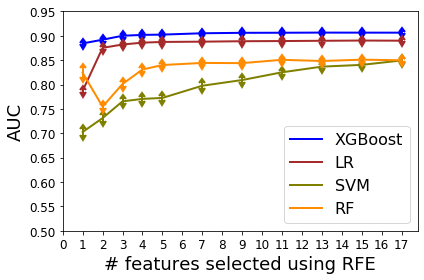

In [77]:
plt.figure(figsize=(6,4))

x = [ 1,2,3,4,5,7,9,11,13,15,17]

LR_Mean_Mode = rfe_AUC_lr.mean()[::-1]
LR_Mean_Mode_etd_er = rfe_AUC_lr.sem(axis = 0)[::-1]

RF_Mean_Mode = rfe_AUC_rf.mean()[::-1]
RF_Mean_Mode_etd_er = rfe_AUC_rf.sem(axis = 0)[::-1]

SVM_Mean_Mode = rfe_AUC_svm.mean()[::-1]
SVM_Mean_Mode_etd_er = rfe_AUC_svm.sem(axis = 0)[::-1]

XGB_Mean_Mode = rfe_AUC_xgb.mean()[::-1]
XGB_Mean_Mode_etd_er = rfe_AUC_xgb.sem(axis = 0)[::-1]

plt.plot(x, XGB_Mean_Mode,'b-',label='XGB_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, XGB_Mean_Mode, yerr=XGB_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='b', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, LR_Mean_Mode,'-',color ='brown',label='LR_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, LR_Mean_Mode, yerr=LR_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='brown',linewidth=2, capthick=2, uplims=True, lolims=True)

plt.plot(x, SVM_Mean_Mode,'-',color ='olive',label='SVM_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, SVM_Mean_Mode, yerr=SVM_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='olive', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, RF_Mean_Mode,'-',color = 'darkorange',label='RF_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, RF_Mean_Mode, yerr=RF_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='darkorange',linewidth=2, capthick=2,uplims=True, lolims=True)

#plt.title('AUC', fontsize=24)
plt.xlabel('# features selected using RFE', fontsize=18)
plt.xticks(np.arange(0, 18, step=1), fontsize=12)#, rotation=45)
plt.yticks( fontsize=12)
plt.ylabel('AUC', fontsize=18)
plt.ylim([0.5,0.95])
plt.legend(( 'XGBoost','LR', 'SVM','RF'), loc='lower right', fontsize=16)

plt.tight_layout()
# save the figure in tiff file
plt.savefig("Figure_2B.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

